In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


In [2]:
ff5_data = pd.read_csv('data/raw/ff5_data.csv')
ff5_data['Date'] = pd.to_datetime(ff5_data['Date'].astype(str), format='%Y%m%d', errors='coerce')
ff5_data = ff5_data.dropna(subset=['Date']).set_index('Date').sort_index()
ff5_data = ff5_data / 100.0

spy_returns = pd.read_csv('data/raw/spy_monthly_returns.csv', index_col=0)
spy_returns.index = pd.to_datetime(spy_returns.index, errors='coerce')
spy_returns = spy_returns[spy_returns.index.notna()]
spy_returns = spy_returns.rename(columns={'SPY': 'SPY_returns'})

sp500_returns = pd.read_csv('data/raw/market_data.csv', index_col=0)
sp500_returns.index = pd.to_datetime(sp500_returns.index, errors='coerce')
sp500_returns = sp500_returns[sp500_returns.index.notna()]

print("Data loaded successfully!")
print(f"FF5 data: {ff5_data.shape}")
print(f"SPY returns: {spy_returns.shape}")
print(f"SP500 returns: {sp500_returns.shape}")

Data loaded successfully!
FF5 data: (15690, 6)
SPY returns: (250, 1)
SP500 returns: (250, 503)


#### Fama-French 5 Factors 

**Mkt-RF (Market Risk Premium)**  
Market return minus risk-free rate. Measures if stocks beat safe investments.

**SMB (Small Minus Big)**  
Small-cap vs large-cap performance. Captures size effect.

**HML (High Minus Low)**  
Value stocks vs growth stocks. The "value premium."

**RMW (Robust Minus Weak)**  
Profitable vs unprofitable companies. Quality factor.

**CMA (Conservative Minus Aggressive)**  
Conservative vs aggressive investors. Investment discipline factor.

**RF (Risk-Free Rate)**  
Return on safe investments (T-bills). Baseline return.


##### Interpreting Positive vs Negative Values

| Factor | Positive Means | Negative Means |
|--------|---------------|----------------|
| **Mkt-RF** | Stocks beat bonds | Bonds beat stocks |
| **SMB** | Small caps win | Large caps win |
| **HML** | Value stocks win | Growth stocks win |
| **RMW** | Profitable firms win | Unprofitable firms win |
| **CMA** | Conservative wins | Aggressive wins |
| **RF** | Higher safe returns | Lower safe returns |

#### data exploration

In [3]:
# limit data to understandable range
ff5_recent = ff5_data.loc['2005-01-01':]
print(f"Data range: {ff5_recent.index[0]} to {ff5_recent.index[-1]}")
print(f"Shape: {ff5_recent.shape}")
print("\nFirst 10 rows:")
print(ff5_recent.head(10))

Data range: 2005-01-03 00:00:00 to 2025-10-31 00:00:00
Shape: (5242, 6)

First 10 rows:
            Mkt-RF     SMB     HML     RMW     CMA      RF
Date                                                      
2005-01-03 -0.0097 -0.0063 -0.0005  0.0035 -0.0001  0.0001
2005-01-04 -0.0130 -0.0051  0.0044  0.0083 -0.0048  0.0001
2005-01-05 -0.0051 -0.0114  0.0002  0.0004 -0.0013  0.0001
2005-01-06  0.0034 -0.0003  0.0013  0.0052 -0.0012  0.0001
2005-01-07 -0.0022 -0.0084 -0.0010 -0.0015 -0.0002  0.0001
2005-01-10  0.0042  0.0029  0.0012  0.0000 -0.0023  0.0001
2005-01-11 -0.0068 -0.0029  0.0037  0.0088 -0.0017  0.0001
2005-01-12  0.0038 -0.0009 -0.0009 -0.0022  0.0012  0.0001
2005-01-13 -0.0077  0.0024  0.0039  0.0005  0.0001  0.0001
2005-01-14  0.0066  0.0050  0.0004 -0.0019  0.0015  0.0001


In [4]:
# 3.2 Main characteristics of data
print("\n=== SUMMARY STATISTICS ===")
print(ff5_recent.describe())

print("\n=== DATA TYPES ===")
print(ff5_recent.dtypes)

print("\n=== MISSING VALUES ===")
missing = ff5_recent.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values")

# Drop rows with missing values
ff5_recent = ff5_recent.dropna()

# Convert index to datetime if not already
ff5_recent.index = pd.to_datetime(ff5_recent.index)

# Convert daily factor data to monthly data.
# RF is a daily simple rate; we compound it to get monthly RF.
rf_monthly = (1 + ff5_recent['RF']).resample('M').prod() - 1

# Mkt-RF is an excess return. To aggregate correctly, build the market total return first,
# then subtract the compounded monthly RF.
mkt_total_daily = ff5_recent['Mkt-RF'] + ff5_recent['RF']
mkt_total_monthly = (1 + mkt_total_daily).resample('M').prod() - 1
mkt_rf_monthly = mkt_total_monthly - rf_monthly

# Style factors are long/short portfolio returns; we compound within the month.
other_factors = ['SMB', 'HML', 'RMW', 'CMA']
other_monthly = (1 + ff5_recent[other_factors]).resample('M').prod() - 1

ff5_monthly = pd.concat(
    [mkt_rf_monthly.rename('Mkt-RF'), other_monthly, rf_monthly.rename('RF')],
    axis=1
)

# Align to month-start timestamps (matches SPY monthly return index)
ff5_monthly.index = ff5_monthly.index.to_period('M').to_timestamp()


=== SUMMARY STATISTICS ===
            Mkt-RF          SMB          HML          RMW          CMA  \
count  5242.000000  5242.000000  5242.000000  5242.000000  5242.000000   
mean      0.000421    -0.000024    -0.000034     0.000125    -0.000008   
std       0.012247     0.006396     0.007982     0.004586     0.003946   
min      -0.120100    -0.045800    -0.050300    -0.027100    -0.029200   
25%      -0.004300    -0.003700    -0.003500    -0.002400    -0.002000   
50%       0.000700    -0.000100    -0.000200     0.000100    -0.000100   
75%       0.006000     0.003500     0.003200     0.002500     0.001900   
max       0.113600     0.057100     0.067300     0.042500     0.024700   

                RF  
count  5242.000000  
mean      0.000067  
std       0.000083  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000100  
max       0.000200  

=== DATA TYPES ===
Mkt-RF    float64
SMB       float64
HML       float64
RMW       float64
CMA       float64
RF    

In [5]:
ff5_monthly

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2005-01-01,-0.027735,-0.011014,0.021046,0.028971,-0.014525,0.002002
2005-02-01,0.018765,-0.002827,0.014022,0.012924,-0.002025,0.001902
2005-03-01,-0.019641,-0.014406,0.021232,0.004640,0.013652,0.002202
2005-04-01,-0.026120,-0.040480,0.000432,0.009965,-0.009089,0.002102
2005-05-01,0.036674,0.027503,-0.005475,-0.009930,0.002468,0.002102
...,...,...,...,...,...,...
2025-06-01,0.048675,0.000082,-0.015139,-0.029946,0.013773,0.004008
2025-07-01,0.019862,-0.000945,-0.012762,-0.003399,-0.020352,0.004409
2025-08-01,0.018490,0.048683,0.042643,-0.006815,0.019643,0.004208


#### plot FF factors with historical context

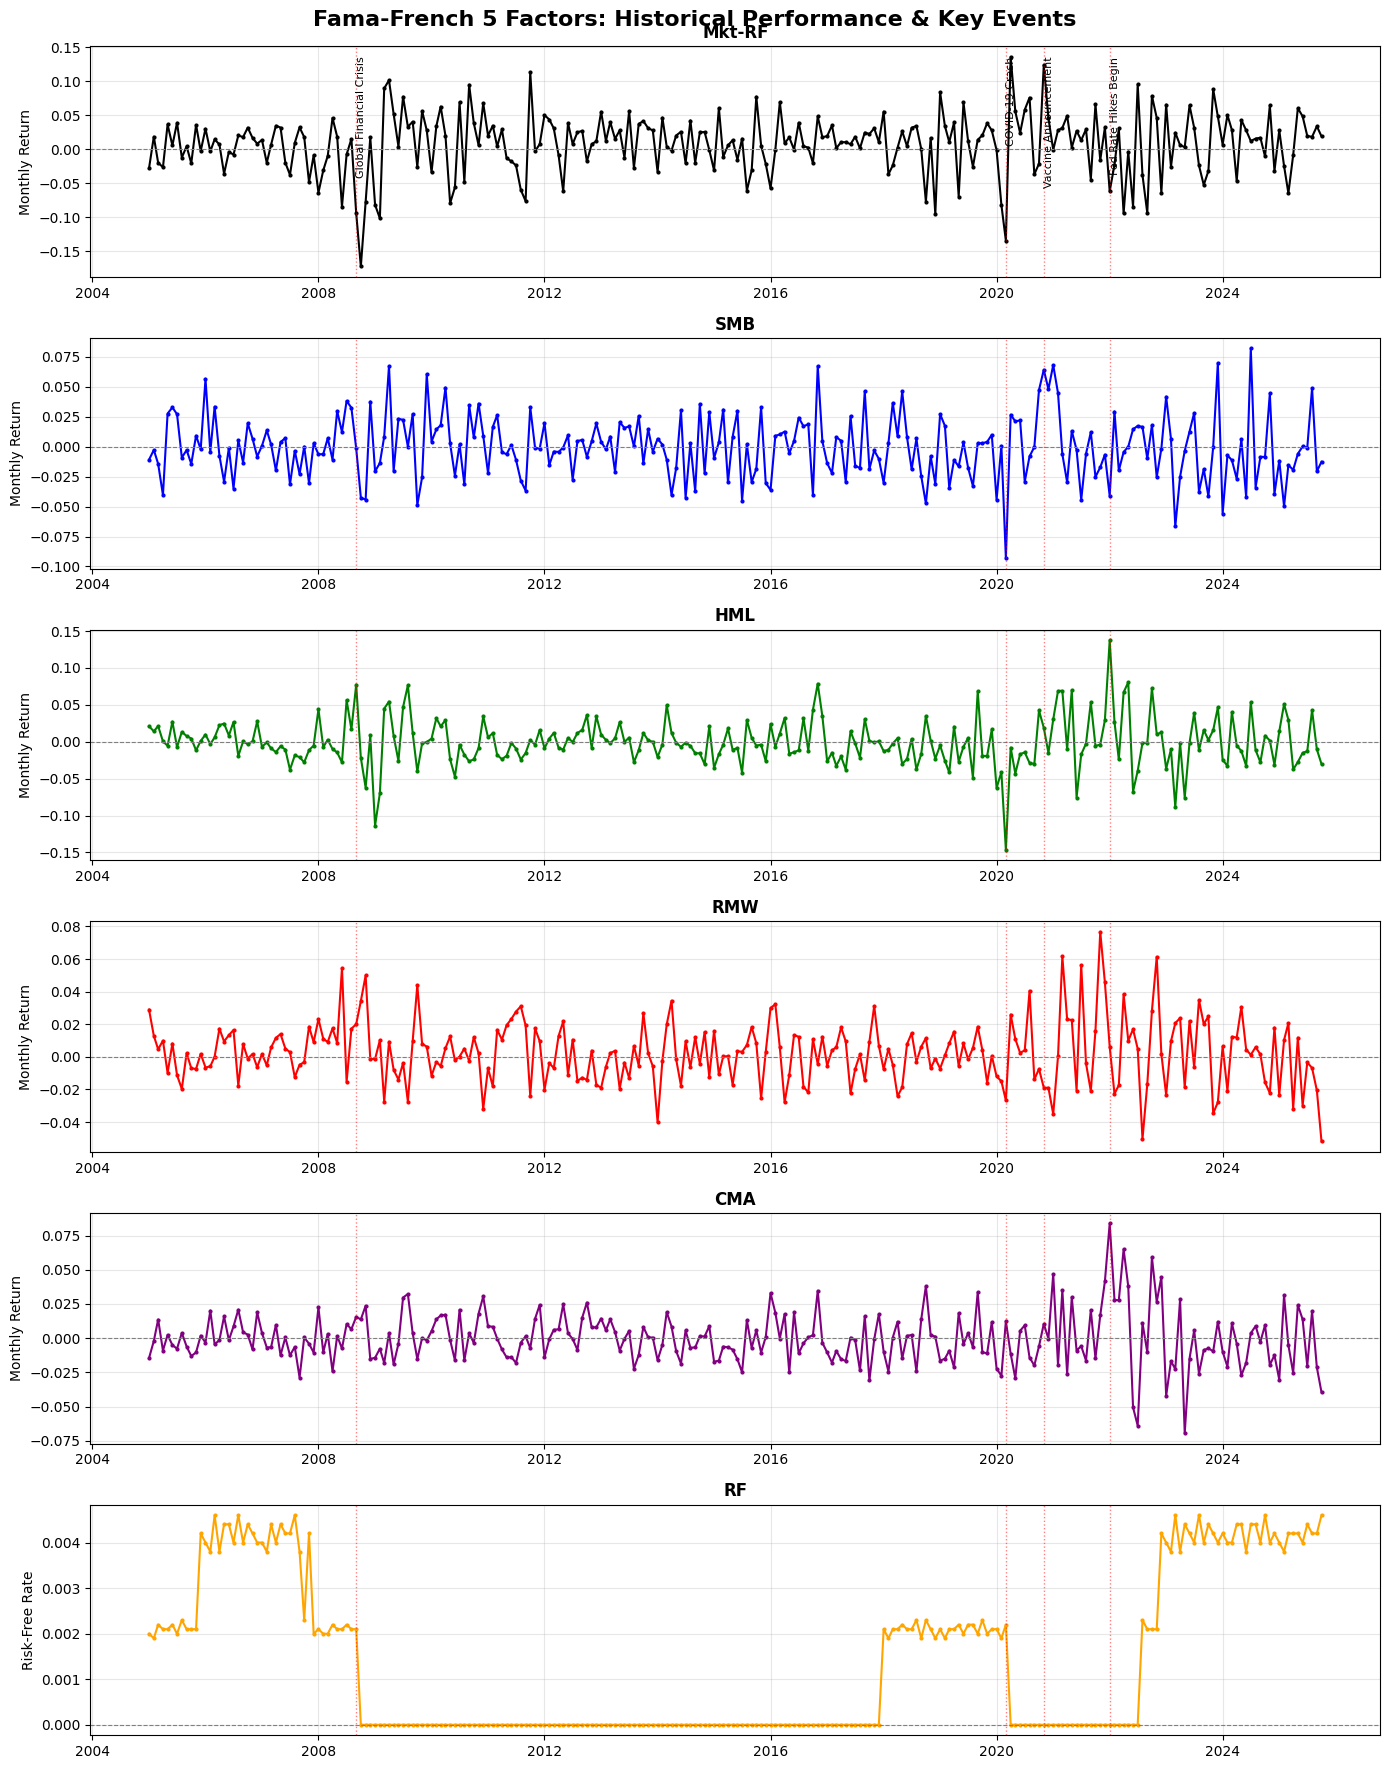

Original data points: 5242
Monthly sampled points: 250


In [6]:
fig, axes = plt.subplots(6, 1, figsize=(14, 18))
fig.suptitle('Fama-French 5 Factors: Historical Performance & Key Events', 
             fontsize=16, fontweight='bold')

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
colors = ['black', 'blue', 'green', 'red', 'purple', 'orange']

# Key historical events to annotate
events = {    
    '2008-09': 'Global Financial Crisis',
    '2020-03': 'COVID-19 Crash',
    '2020-11': 'Vaccine Announcement',
    '2022-01': 'Fed Rate Hikes Begin',    
}

for i, (factor, color) in enumerate(zip(factors, colors)):
    # Plot the time series
    axes[i].plot(ff5_monthly.index, ff5_monthly[factor], color=color, linewidth=1.5, marker='o', markersize=2)
    axes[i].set_title(f'{factor}', fontsize=12, fontweight='bold')
    
    # Better y-axis label based on what FF data actually is
    if factor == 'RF':
        axes[i].set_ylabel('Risk-Free Rate', fontsize=10)
    else:
        axes[i].set_ylabel('Monthly Return', fontsize=10)
    
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    
    # Add event annotations
    for date, event in events.items():
        event_date = pd.to_datetime(date)
        if event_date >= ff5_monthly.index.min() and event_date <= ff5_monthly.index.max():
            axes[i].axvline(x=event_date, color='red', 
                          linestyle=':', alpha=0.5, linewidth=1)
            # Add text label only on first subplot
            if i == 0:
                axes[i].text(event_date, axes[i].get_ylim()[1]*0.9, event, 
                           rotation=90, verticalalignment='top', fontsize=8)

plt.tight_layout()
plt.show()

print(f"Original data points: {len(ff5_recent)}")
print(f"Monthly sampled points: {len(ff5_monthly)}")

#### Statistical Method #1 – Distribution & Summary Statistics


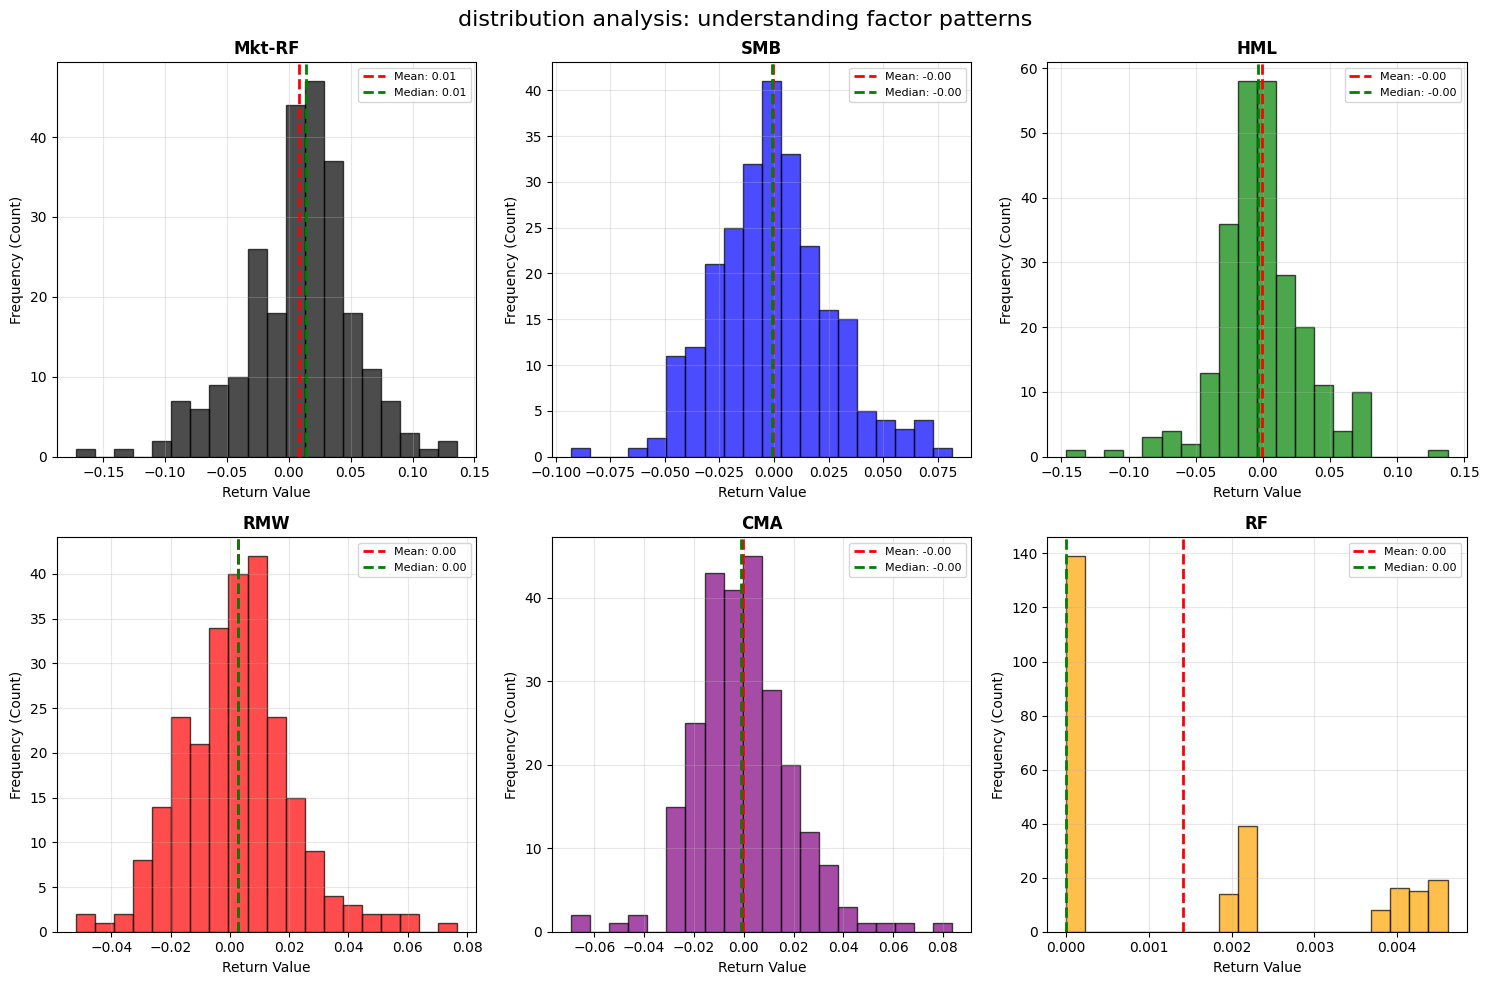

In [7]:

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('distribution analysis: understanding factor patterns', fontsize=16)

axes = axes.flatten()
for i, factor in enumerate(factors):
    # Simple histogram
    axes[i].hist(ff5_monthly[factor], bins=20, alpha=0.7, color=colors[i], edgecolor='black')
    
    # Add mean line
    mean_val = ff5_monthly[factor].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    
    # Add median line
    median_val = ff5_monthly[factor].median()
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    axes[i].set_title(f'{factor}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Return Value', fontsize=10)
    axes[i].set_ylabel('Frequency (Count)', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# statistics
print("\n=== STATISTICS FOR EACH FACTOR ===\n")
for factor in factors:
    print(f"{factor}:")
    print(f"  Mean (Average):     {ff5_monthly[factor].mean():.4f}")
    print(f"  Median (Middle):    {ff5_monthly[factor].median():.4f}")
    print(f"  Std Dev (Spread):   {ff5_monthly[factor].std():.4f}")
    print()

# check for symmetry 
print("\n=== IS THE DATA BALANCED? ===\n")
for factor in factors:
    mean_val = ff5_monthly[factor].mean()
    median_val = ff5_monthly[factor].median()
    std_dev = ff5_monthly[factor].std()
    
    if abs(mean_val - median_val) < 0.1 * std_dev:
        balance = " Balanced (mean ≈ median)"
    elif mean_val > median_val:
        balance = " Right-skewed (more extreme positive values)"
    else:
        balance = " Left-skewed (more extreme negative values)"
    
    print(f"{factor}: {balance}")


=== STATISTICS FOR EACH FACTOR ===

Mkt-RF:
  Mean (Average):     0.0083
  Median (Middle):    0.0135
  Std Dev (Spread):   0.0444

SMB:
  Mean (Average):     -0.0006
  Median (Middle):    -0.0009
  Std Dev (Spread):   0.0266

HML:
  Mean (Average):     -0.0008
  Median (Middle):    -0.0033
  Std Dev (Spread):   0.0323

RMW:
  Mean (Average):     0.0026
  Median (Middle):    0.0026
  Std Dev (Spread):   0.0190

CMA:
  Mean (Average):     -0.0002
  Median (Middle):    -0.0010
  Std Dev (Spread):   0.0192

RF:
  Mean (Average):     0.0014
  Median (Middle):    0.0000
  Std Dev (Spread):   0.0017


=== IS THE DATA BALANCED? ===

Mkt-RF:  Left-skewed (more extreme negative values)
SMB:  Balanced (mean ≈ median)
HML:  Balanced (mean ≈ median)
RMW:  Balanced (mean ≈ median)
CMA:  Balanced (mean ≈ median)
RF:  Right-skewed (more extreme positive values)


In [9]:
ff5_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].describe()


,Mkt-RF,SMB,HML,RMW,CMA,RF
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.008269,-0.000589,-0.000849,0.002576,-0.000159,0.001418
std,0.044389,0.026621,0.032316,0.019001,0.019188,0.001740
min,-0.172062,-0.093032,-0.146437,-0.051894,-0.069334,0.000000
25%,-0.017638,-0.018432,-0.017448,-0.007863,-0.012382,0.000000
50%,0.013542,-0.000866,-0.003298,0.002644,-0.001038,0.000000
75%,0.033872,0.014471,0.013992,0.012318,0.010395,0.002303
max,0.136169,0.081782,0.137614,0.076685,0.083789,0.004610


**Quantitative conclusion (Method #1):**

From the summary statistics and distributions:

- **Mkt-RF** is the dominant driver of variability among the factors (it has the largest spread/volatility).
- **SMB, HML, RMW, CMA** are smaller “tilt” factors that tend to be closer to zero on average and have lower volatility than the market factor.
- **RF** is comparatively small and stable.

Overall, this distribution analysis supports the intuition that the market factor explains most broad market movement, while the other FF factors provide secondary style exposures that can matter more in specific regimes.

#### Statistical Method #2 – Outliers via Boxplots + IQR Rule


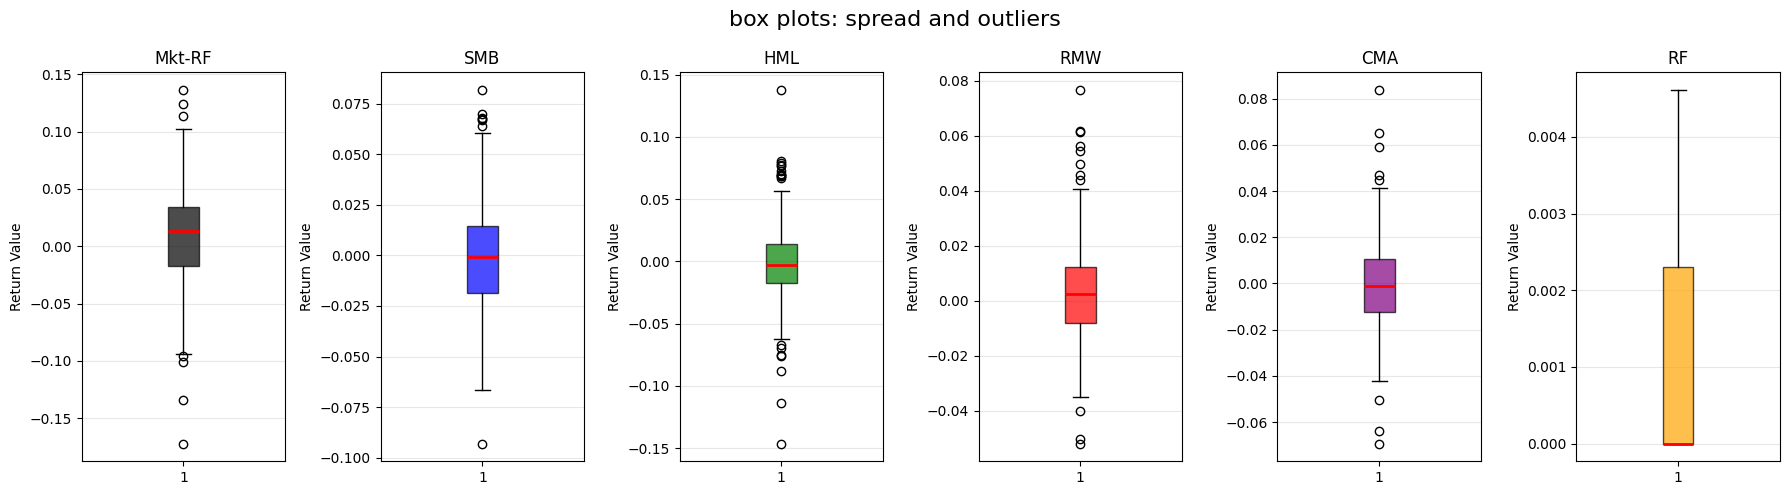

- Box: Middle 50% of data (25th to 75th percentile)
- Red line: Median (middle value)
- Whiskers: Typical range of data
- Dots: Outliers (unusual extreme values)


In [10]:

# box plots to see spread and outliers
fig, axes = plt.subplots(1, 6, figsize=(18, 5))
fig.suptitle('box plots: spread and outliers', fontsize=16)

for i, factor in enumerate(factors):
    axes[i].boxplot(ff5_monthly[factor], patch_artist=True,
                   boxprops=dict(facecolor=colors[i], alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
    axes[i].set_title(factor, fontsize=12)
    axes[i].set_ylabel('Return Value', fontsize=10)
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("- Box: Middle 50% of data (25th to 75th percentile)")
print("- Red line: Median (middle value)")
print("- Whiskers: Typical range of data")
print("- Dots: Outliers (unusual extreme values)")

In [11]:
# Outlier detection using IQR rule
outlier_counts = {}

print("=== OUTLIER COUNTS USING IQR RULE ===")
for factor in factors:
    q1 = ff5_monthly[factor].quantile(0.25)
    q3 = ff5_monthly[factor].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    mask = (ff5_monthly[factor] < lower) | (ff5_monthly[factor] > upper)
    count = mask.sum()
    outlier_counts[factor] = count

    print(f"{factor}: {count} outliers "
          f"(lower={lower:.4f}, upper={upper:.4f})")



=== OUTLIER COUNTS USING IQR RULE ===
Mkt-RF: 7 outliers (lower=-0.0949, upper=0.1111)
SMB: 7 outliers (lower=-0.0678, upper=0.0638)
HML: 18 outliers (lower=-0.0646, upper=0.0612)
RMW: 11 outliers (lower=-0.0381, upper=0.0426)
CMA: 8 outliers (lower=-0.0465, upper=0.0446)
RF: 0 outliers (lower=-0.0035, upper=0.0058)


**Outlier rule and policy (Method #2):**

- We define outliers using the standard IQR rule: any value below Q1 − 1.5·IQR or above Q3 + 1.5·IQR.
- Each factor has only a small number of outliers relative to the total number of months, and these points correspond to real market stress periods (e.g., crises, crashes).
- Because we want our model to capture real extreme events, we **keep** these outliers in the dataset instead of removing or winsorizing them. We will, however, check model diagnostics later to ensure they don’t completely dominate the regression.


#### Statistical Method #3 – Correlation & Hypothesis Test (SPY vs FF5 Factors)

We align data to a monthly frequency (by compounding daily data within each month). Because `Mkt-RF` is defined as an **excess return**, we compare **SPY excess returns (SPY − RF)** to the FF5 factors at a monthly frequency.

**Notes for reproducibility / interpretation:**

- All returns/factors are in **decimal form** (e.g., 0.02 = 2%).
- FF5 data availability can lag the latest market month; we use an **inner join** so this analysis uses only months present in both datasets.


=== HOW RELATED ARE FACTORS TO SPY? (MONTHLY, EXCESS-RETURN ALIGNED) ===
Correlation ranges from -1 to +1:
  +1 = Perfect positive relationship (move together)
   0 = No relationship
  -1 = Perfect negative relationship (move opposite)

Mkt-RF    0.990466
SMB       0.304479
HML       0.138650
RF       -0.057112
CMA      -0.113793
RMW      -0.147611
Name: SPY_excess, dtype: float64


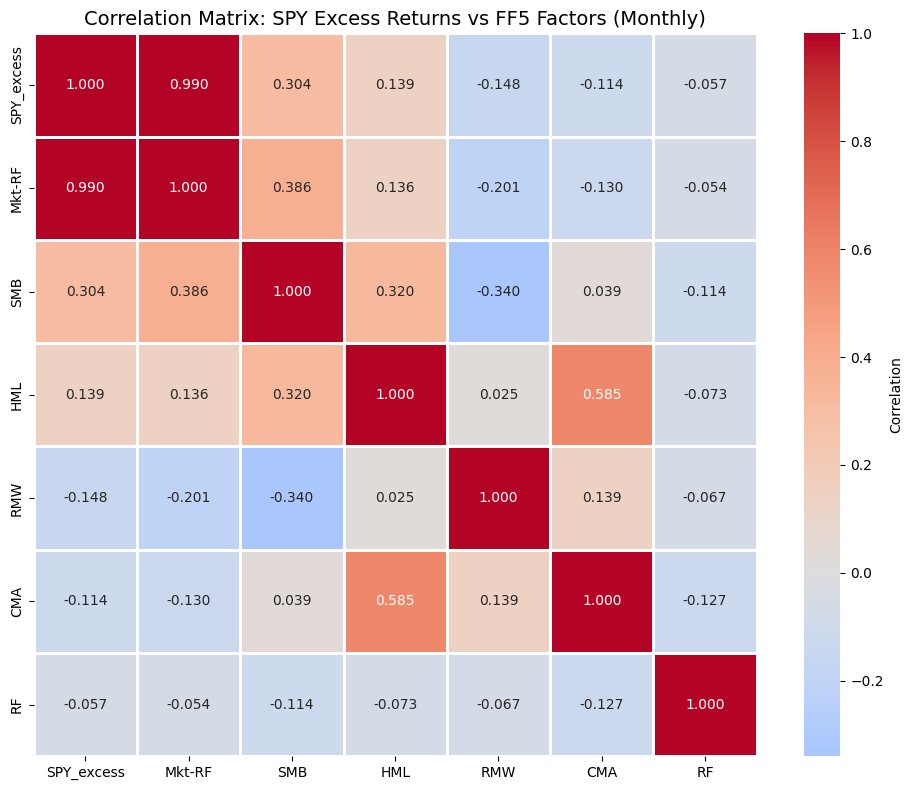


=== WHAT DOES THIS MEAN? ===
Strongest relationship: Mkt-RF (correlation = 0.990)
This factor moves most closely with SPY excess returns

Weakest relationship: RF (correlation = -0.057)
This factor has little connection to SPY excess returns


In [12]:
combined = pd.DataFrame(spy_returns)
combined = combined.join(ff5_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']], how='inner')

# Use SPY excess returns to match the definition of Mkt-RF (market excess return)
combined['SPY_excess'] = combined['SPY_returns'] - combined['RF']

print("\n=== HOW RELATED ARE FACTORS TO SPY? (MONTHLY, EXCESS-RETURN ALIGNED) ===")
print("Correlation ranges from -1 to +1:")
print("  +1 = Perfect positive relationship (move together)")
print("   0 = No relationship")
print("  -1 = Perfect negative relationship (move opposite)\n")

correlations = combined.corr()['SPY_excess'].drop(['SPY_returns', 'SPY_excess']).sort_values(ascending=False)
print(correlations)

plt.figure(figsize=(10, 8))
cols = ['SPY_excess', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
sns.heatmap(combined[cols].corr(), annot=True, cmap='coolwarm', center=0,
            fmt='.3f', square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix: SPY Excess Returns vs FF5 Factors (Monthly)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n=== WHAT DOES THIS MEAN? ===")
strongest = correlations.abs().idxmax()
print(f"Strongest relationship: {strongest} (correlation = {correlations[strongest]:.3f})")
print("This factor moves most closely with SPY excess returns")

weakest = correlations.abs().idxmin()
print(f"\nWeakest relationship: {weakest} (correlation = {correlations[weakest]:.3f})")
print("This factor has little connection to SPY excess returns")

##### Key Learnings from Correlation Analysis

- The factor with the largest absolute correlation (printed above) is the one most closely related to **SPY excess returns** in this sample.
- In practice, **Mkt-RF** is typically expected to be the dominant driver because SPY closely tracks the broad market.
- The remaining factors (SMB/HML/RMW/CMA) are style tilts and can be weaker or regime-dependent.
- **RF** often shows a weak relationship with equity **excess** returns (and we already subtract RF when forming SPY excess returns).

Use the printed correlation values and heatmap above for the exact magnitudes in this run.

#### Formal hypothesis test on correlation (Method #3)

- H₀ (null): true correlation between **SPY excess returns** and **Mkt-RF** is 0.
- H₁ (alternative): true correlation is not 0.
- α = 0.05, Pearson correlation test.

In [13]:
valid = combined[['SPY_excess', 'Mkt-RF']].dropna()

r, p_value = pearsonr(valid['SPY_excess'], valid['Mkt-RF'])

print("=== PEARSON CORRELATION TEST: SPY Excess vs Mkt-RF ===")
print(f"Correlation coefficient (r): {r:.3f}")
print(f"p-value: {p_value:.4g}")

=== PEARSON CORRELATION TEST: SPY Excess vs Mkt-RF ===
Correlation coefficient (r): 0.990
p-value: 1.171e-214


**Hypothesis test result (Method #3):**

Use the printed values above:
- `r` is the sample correlation between monthly **SPY excess returns** and monthly `Mkt-RF`.
- `p-value` determines statistical significance.

Decision rule at α = 0.05:
- If `p-value < 0.05`, reject H₀ (evidence correlation is not zero).
- If `p-value >= 0.05`, do not reject H₀.

In either case, `Mkt-RF` remains an economically important factor in the Fama-French framework; this test only evaluates linear correlation in this sample.